# 02-PROPELLER EXAMPLE<img src="logo.png" style="float:right; max-width: 180px; display: inline" alt="logo" /></a>

# Propellers estimation models with dimensional analysis and variable power-law model regression

*Originally written by Marc Budinger, INSA Toulouse, France*<br>
*Adapted to illustrate pyVPLM application case*

## 1 - Introduction
<a id="1"></a>
Nowadays, the drone industry market is booming replacing costly solution for maintenance (bridge, railway catenary, aircraft... inspections), military air force, video shooting, and new services are still under investigation: delivery, personal transport...
<figure>
    <img src="./02_propeller_example/ELIX_XXL_drone.jpg" alt="ELIX_XL" style="height:300px">
    <figcaption>Fig.1 - ELIX-XL military drone.</figcaption>
</figure>

Drone design is extremely linked to its mission purpose. Therefore even small companies are facing preliminary sizing problematic electing from suppliers propeller, motor, battries type, number, dimension to fit their need.<br>
This "election" is way simpler if estimation model (or mathematic formulas) with limited number of parameters to handle can replace big data tables.<br>

We will illustrate in this notebook how we can construct estimation models for propellers sizing and more precisely how the $C_T$ and $C_P$ coefficients (design drivers for the propulsion chain) can be estimated from a limited set of propeller's parameters.<br>

We will begin first with a dimensional analysis on datasheet parameters and then try to find surrogate model using variable power-law regression finishing with more suitable linear regression of a $3^{rd}$ order expression.<br>

<font color=blue>Table of contents:</font><br>
[1 - Introduction](#1-Introduction)<br>
[2 - Dimensional analysis and $\pi$ numbers](#2)<br>
[2.1 - Dimensional analysis on the propeller thrust - $C_{t}$ coefficient](#2.1)<br>
[2.2 - Dimensional analysis on the mechanical power  - $C_{p}$ coefficient](#2.2)<br>
[3 - $C_{t}$ surrogate model construction for static case](#3)<br>
[3.1 - Variable power-law regression: take-off ($V=J=0$)](#3.1)<br>
[3.2 - Polynomial regression: take-off ($V=J=0$)](#3.2)<br>
[4 - $C_{t}$ surrogate model construction for dynamic case](#4)<br>
[4.1 - Variable power-law regression: normal flight ($ \ne 0mph$)](#4.1)<br>
[4.2 - Polynomial regression: normal flight ($V \ne 0mph$)](#4.2)<br>

## 2 - Dimensional analysis and $\pi$ numbers [§](#1)
<a id="2"></a>

When we look at APC manufacturer [datasheets](https://www.apcprop.com/technical-information/performance-data/) we have following table (for 10.5x4.5.dat):
<figure>
    <img src="./02_propeller_example/apc_10.5x4.5.png" alt="APC" style="height:170px">
    <figcaption>Fig.2 - APC 10.5*4.5 inch propeller.</figcaption>
</figure>


The propeller mechanical equations linking mechanical power and thrust to $C_{T}$ and $C_{p}$ aerodynamic coefficients are:
- $Thrust = C_{T} \cdot \rho \cdot n^2 \cdot D^4$  
- $P = C_{P} \cdot \rho \cdot n^3 \cdot D^5$<br>
Where **$\rho$** represents the air density, **$n$** the rotarional RPM speed and **$D$** the propeller diameter (here 10.5 inches).

Let us consider an additional parameter, the air bulk modulus $\beta$, and see if an automatic research of $\pi$ dimensionless parameters considering thrust depends on following parameters (geometrical dimensions, air properties, operational points): $T=f(\rho,n,D,pitch,V,\beta)$ will highligh similar coefficient.

> **Note**: To read more about [dimensional analysis](https://web.mit.edu/16.unified/www/FALL/thermodynamics/notes/node86.html#SECTION06374000000000000000) and especially [Buckingham $\pi$ theorem](https://en.wikipedia.org/wiki/Buckingham_%CF%80_theorem).


### 2.1 - Dimensional analysis on the propeller thrust  - $C_{t}$ coefficient [§](#1)
<a id="2.1"></a>

Parameter|M|L|T|
--|--|--|--
Thrust $T$ [N] | 1|1|-2
Air density $\rho$ [kg/m$^3$]| 1 | -3 | 0|
Rotational speed $n$ [Hz] | 0 | 0 | -1|
Diameter $D$ [m] | 0| 1 | 0|
Pitch $Pitch$ [m] | 0 | 1 | 0|
Air speed $V$ [m/s] | 0 | 1 | -1|
Air bulk modulus $\beta$ [Pa] | 1 | -1 | -2|
$=\pi_0$|  |  |  |
$=\pi_1$|  |  |  |
$=\pi_2$|  |  |  |
$=\pi_3$|  |  |  |


Table sum-up the considered parameters where each dimension is expressed as a power of fundamental dimensions **L [Length]**, **M [Mass]** and **T [Time]**: $[x]=M^aL^bT^c$. 

> **Exercice**: Complete the table with 4 dimensionless $\pi$ numbers possible for the given problem. Explain the number of dimensionless number.

In [1]:
# Import pyVPLM modules/functions
from pyvplm.core.definition import PositiveParameter, PositiveParameterSet # load classes used for VPLM
from pyvplm.addon.variablepowerlaw import buckingham_theorem # load buckingham theorem

# Declare physical variables and set (limits have no impact since DOE is not constructed)
t = PositiveParameter('t', [0.01, 100], 'N', 'trust')
RHO = PositiveParameter('RHO', [1.184],'kg/m^3','air density')
n = PositiveParameter('n', [0.1, 1500], 'rad/s', 'rotational speed')
d = PositiveParameter('d', [3, 50], 'cm', 'propeller diameter')
pitch = PositiveParameter('pitch', [1, 10], 'inch', 'propeller pitch')
v = PositiveParameter('v', [0.01, 10], 'm/s', 'air speed')
BETA = PositiveParameter('BETA', [101000], 'Pa', 'air bulk modulus')
parameter_set = PositiveParameterSet(t, RHO, n, d,  pitch, v, BETA)

# Define d and lambda_wind to be first elected as repetitive set
parameter_set.first('n', 'd', 'RHO')
parameter_set.latex_render()

# Calculate pi parameters with first repetitive set found in parameters' order
pi_set, _ = buckingham_theorem(parameter_set, False)
pi_set.latex_render()

Defined set is:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>


Defined set is:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

**Answer:**

Buckingham $\pi$ theorem gives: 7 parameters - 3 dimensions = 4 dimensionless $\pi$ numbers

Parameter|M|L|T|
--|--|--|--
Thrust $T$ [N] | 1|1|-2
Mass volumic (Air) $\rho$ [kg/m$^3$]| 1 | -3 | 0|
Rotational speed $n$ [Hz] | 0 | 0 | -1|
Diameter $D$ [m] | 0| 1 | 0|
Pitch $Pitch$ [m] | 0 | 1 | 0|
Drone speed $V$ [m/s] | 0 | 1 | -1|
Air bulk modulus $\beta$ [Pa] | 1 | -1 | -2|
$\frac{T}{\rho n^2 D^4}=C_t=\pi_1'$| 0 | 0 | 0 |
$\frac{Pitch}{D}=angle=\pi_2$| 0 | 0 | 0 |
$\frac{V}{nD}=J=\frac{1}{pi_3}=\pi_3'$| 0 | 0 | 0 |
$\frac{D^2 n^2 \rho}{\beta}=\pi_4$| 0 | 0 | 0 |

We find the $C_{t}$ coefficient expression.

> Note: test force_buckingham function to set new $\Pi$ expressions

In [2]:
# Import pyVPLM modules/functions
from pyvplm.addon.variablepowerlaw import force_buckingham # load buckingham theorem

# Force expressions
pi_set=force_buckingham(parameter_set, 't/(RHO*n**2*d**4)','pitch/d','v/(n*d)','d**2*n**2*RHO/BETA')
pi_set.latex_render()

Defined set is:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### 2.2 - Dimensional analysis on the mechanical power  - $C_{p}$ coefficient [§](#1)
<a id="2.2"></a>
Similar analysis can be performed on mechanical power.

In [3]:
# Define power parameter and create new set to higligh power relation
p = PositiveParameter('p', [0.0001, 100], 'W', 'mechanical power')
parameter_set2 = PositiveParameterSet(RHO, n, d,  pitch, v, BETA, p)
parameter_set2.first('RHO', 'n', 'd')

# Calculate pi parameters with first repetitive set found in parameters' order
pi_set2, _ = buckingham_theorem(parameter_set2, track=False)
pi_set2.latex_render()

Defined set is:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

The **$C_{p}$** coefficient is expressed by **$\pi_4'=\frac{1}{\pi_4}=\frac{p}{d^5n^3\rho}$**.

## 3 - $C_{t}$ surrogate model construction for static case [§](#1)
<a id="3"></a>

### 3.1 - Variable power-law regression: take-off ($V=J=0$) [§](#1)
<a id="3.1"></a>
APC suppliers give complete data for all their propellers and especially [PER2_STATIC-2.DAT](https://www.apcprop.com/files/PER2_STATIC-2.DAT) file from wich ***APC_STATIC-data-all-props.csv*** derives.<br>
Let us load this file and look at the stored data.

In [4]:
# Import additional libs
import pandas

# Read the .csv file
df = pandas.read_csv('./02_propeller_example/APC_STATIC-data-all-props.csv', sep=';')
# Print the head (first lines of the file)
df.head(n=3)

,COMP,TYPE,RPM,DIAMETER(IN),PITCH(IN),BLADE(nb),THRUST(LBF),POWER(HP),TORQUE(IN.LBF),Cp,Ct,AREA(m^2),THRUST(N),POWER(W),ANGLE,EFF,N.D
0,1,NaN,1000,10.5,4.5,2,0.03,0.01,0.02,0.03,0.08,0.06,0.1335,7.457,0.43,60.180222,10500.0
1,1,NaN,2000,10.5,4.5,2,0.13,0.01,0.08,0.03,0.08,0.06,0.5785,7.457,0.43,60.180222,21000.0
2,1,NaN,3000,10.5,4.5,2,0.29,0.01,0.17,0.03,0.08,0.06,1.2905,7.457,0.43,60.180222,31500.0


For next steps, we will consider take-off (thus $V=cst=0m/s$ and $\pi_3'$ can be removed) and only the Multi-Rotor type propellers (MR).<br>
But before extracting MR propellers datas, we have to consider a physical phenomena: the $N.D = RPM * D <= 105,000 rpm.inch = 280m/s$ limit.<br>
This [limit](https://www.apcprop.com/technical-information/rpm-limits/) given by the manufacturer is linked to the drop of performance of the propeller and not the critical sound treshold (because tangencial blade speed is only 140m/s, even combined with 90m/s relative air flow leads to 0.5mach).

In [5]:
# Import additional libs
import numpy

# Make little datasheet post-processing keeping only multy-rotor with N.D<=105000 and extract PI-DOE
df_MR=df[df['TYPE']=='MR']
df_MR=df_MR[df_MR['N.D']<=105000]
pi1 = df_MR['Ct']
pi2 = df_MR['PITCH(IN)']/df_MR['DIAMETER(IN)']
pi3 = float(RHO)/float(BETA)*(0.0254*df_MR['DIAMETER(IN)'])**2*(2*3.14/60*df_MR['RPM'])**2
doePI = numpy.c_[numpy.array(pi1), numpy.array(pi2), numpy.array(pi3)]
doePI = pandas.DataFrame(doePI, columns=['pi1', 'pi2', 'pi3'])
doePI.head(n=5)

,pi1,pi2,pi3
0,0.11,0.45,0.033142
1,0.11,0.45,0.074569
2,0.11,0.45,0.132567
3,0.11,0.45,0.207136
4,0.11,0.45,0.298275


> **Exercice**: use regression_models method from SizingLab.variablepowerlaw package to generate 5th order power-law model regression.


Based on following criteria definitions:
1 - C = max(abs(error))
2 - C = mean(abs(error))
3 - C = mean(error)
4 - C = sqrt(1/(n-1)*sum((error-mean(error))²))
Enter selected criteria (1/[2]/3/4)?)


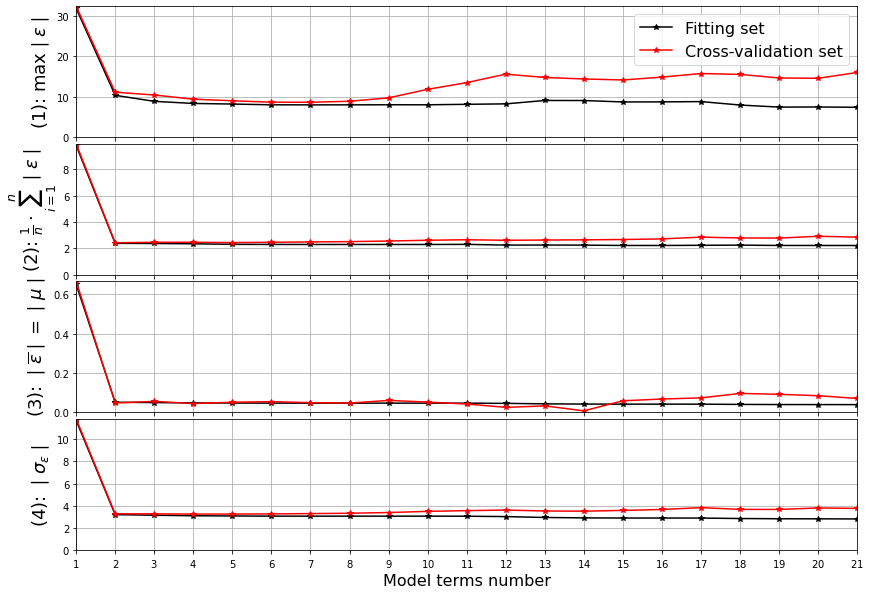

In [6]:
# Import pyVPLM modules/functions
from pyvplm.addon.variablepowerlaw import regression_models

# Fit with 5th order model the obtained Pi DOE pi0=pi1
models = regression_models(doePI.values, elected_pi0='pi1', order=5)

> **Note**: The model quality is not really good, let us plot 5-terms model to highligh error.


Elected model for regression is n°3:


<IPython.core.display.Latex object>

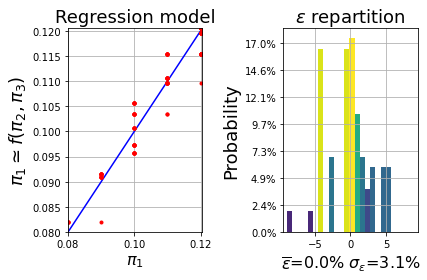

In [7]:
# Import pyVPLM modules/functions
from pyvplm.addon.variablepowerlaw import perform_regression

# Plot advanced result for model n°3
expression, expression_latex = perform_regression(doePI.values, models, chosen_model=3)

### 3.2 - Polynomial regression: take-off ($V=J=0$) [§](#1)
<a id="3.2"></a>
Let us do the same exercice but that time applying linear-regression method to polynomial model.


Based on following criteria definitions:
1 - C = max(abs(error))
2 - C = mean(abs(error))
3 - C = mean(error)
4 - C = sqrt(1/(n-1)*sum((error-mean(error))²))
Enter selected criteria (1/[2]/3/4)?)


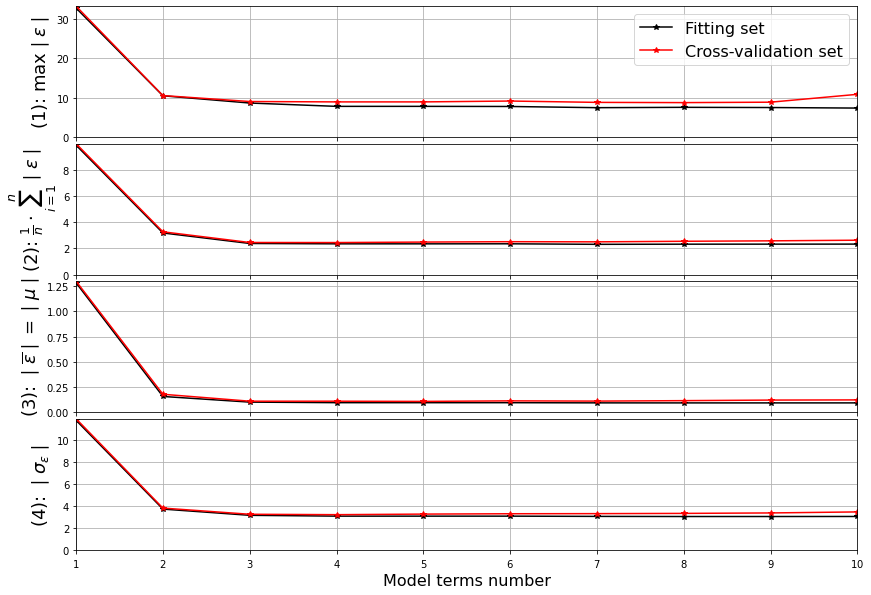


Elected model for regression is n°4:


<IPython.core.display.Latex object>

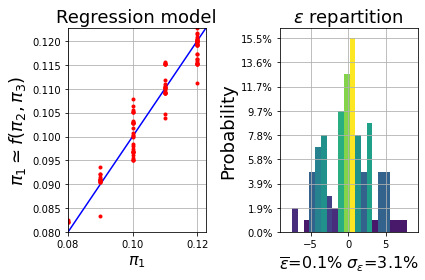

In [9]:
# Import pyVPLM modules/functions
from pyvplm.addon.variablepowerlaw import regression_models, perform_regression

# Fit with 3rd order polynomia model the obtained Pi DOE
models3 = regression_models(doePI.values, elected_pi0='pi1', order=3, log_space=False)

# Plot advanced result for model n°4
expression, expression_latex = perform_regression(doePI.values, models3, chosen_model=4)

> **Conclusion**: Both power-law and polynomial model are not perfect especially if the $C_{t}$ range increase and only capture a trend of the parameter evolution, yet they are beter than a constant value.

## 4 - $C_{t}$ surrogate model construction for dynamic case [§](#1)
<a id="4"></a>

### 4.1 - Variable power-law regression: normal flight ($V\ne 0mph$) [§](#1)
<a id="4.1"></a>

Now we will consider normal flight with different speed rates to fit the datas.<br>
To do so, we will extract multi-rotor dynamic data allready extracted from manufacturer .dat file in ***./02_propeller_example/APC_summary_file.csv*** (you can perform new auto-extraction using ***./02_propeller_example/apc_data/apc_extractor.py*** file on ***.dat*** files) .<br>

In [10]:
# Import additional libs
import pandas

# Read the .csv file
df2 = pandas.read_csv('./02_propeller_example/APC_summary_file.csv', sep=';')
# Print the head (first lines of the file)
df2.head(n=3)

,V (MPH),J,Pe,Ct,Cp,PWR (HP),Torque (IN.LBF),Thrust (LBF),DIAMETER (IN),PITCH (IN),TYPE,BLADE(nb),COMP,RPM
0,0.0,0.00,0.0000,0.1102,0.0428,0.003,0.087,0.140,10,4.5,MR,2,1,2000
1,0.5,0.02,0.0621,0.1086,0.0432,0.003,0.088,0.138,10,4.5,MR,2,1,2000
2,0.9,0.05,0.1212,0.1068,0.0435,0.003,0.088,0.136,10,4.5,MR,2,1,2000


In [11]:
# Import additional libs
import numpy

# Remove all <=0 terms (not to have infinite values in log space) and extract data for regression
df2_reduced=df2[df2['Ct']>=0.01]
df2_reduced=df2_reduced[df2_reduced['J']!=0]
df2_reduced=df2_reduced[(df2_reduced['RPM']*df2_reduced['DIAMETER (IN)'])<=105000]
pi1 = df2_reduced['Ct']
pi2 = df2_reduced['PITCH (IN)']/df2_reduced['DIAMETER (IN)']
pi3 = df2_reduced['J']
pi4 = float(RHO)/float(BETA)*(0.0254*df2_reduced['DIAMETER (IN)'])**2*(2*3.14/60*df2_reduced['RPM'])**2
doePI2 = numpy.c_[numpy.array(pi1), numpy.array(pi2), numpy.array(pi3), numpy.array(pi4)]
doePI2 = pandas.DataFrame(doePI2, columns=['pi1', 'pi2', 'pi3', 'pi4'])
doePI2.head(n=5)

,pi1,pi2,pi3,pi4
0,0.1086,0.45,0.02,0.033142
1,0.1068,0.45,0.05,0.033142
2,0.1050,0.45,0.07,0.033142
3,0.1030,0.45,0.10,0.033142
4,0.1009,0.45,0.12,0.033142



Based on following criteria definitions:
1 - C = max(abs(error))
2 - C = mean(abs(error))
3 - C = mean(error)
4 - C = sqrt(1/(n-1)*sum((error-mean(error))²))
Enter selected criteria (1/[2]/3/4)?)


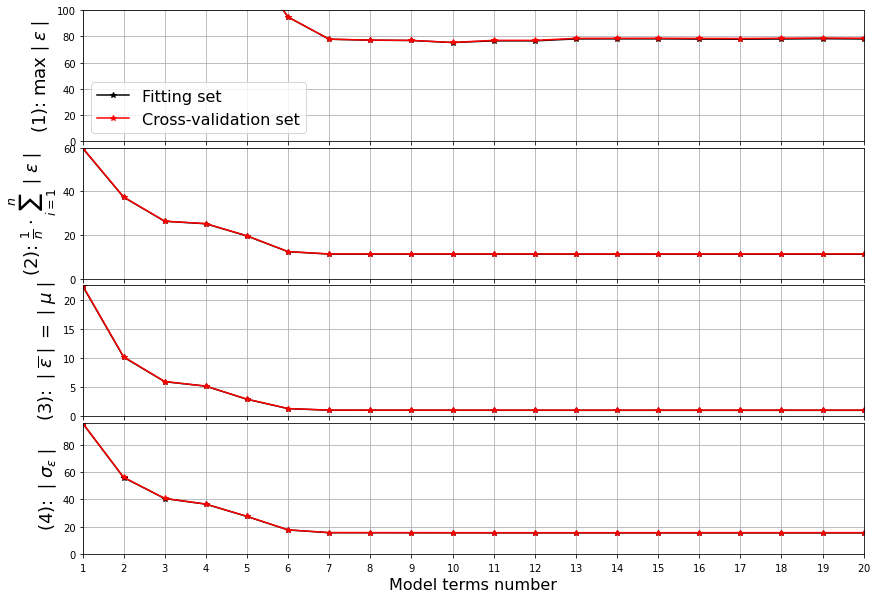

In [12]:
# Import pyVPLM modules/functions
from pyvplm.addon.variablepowerlaw import regression_models

# Fit with 3rd order power-law model the obtained Pi DOE
models4 = regression_models(doePI2.values, elected_pi0='pi1', order=3)


Elected model for regression is n°6:


<IPython.core.display.Latex object>

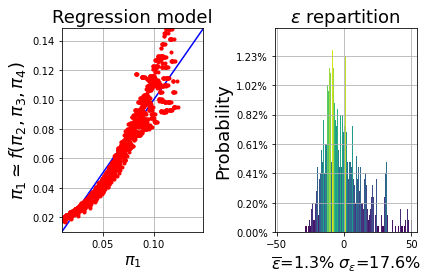

In [13]:
# Import pyVPLM modules/functions
from pyvplm.addon.variablepowerlaw import perform_regression

# Plot advanced result for model n°6
expression, expression_latex = perform_regression(doePI2.values, models4, chosen_model=6)

> **Note**: To have good data fit, model number of terms should be high when considering variable power-law formula. Therefore it can be interesting to see if polynomial form is better.

### 4.2 - Polynomial regression: normal flight ($V\ne 0mph$) [§](#1)
<a id="4.2"></a>

Let us do the same exercice but that time applying linear-regression method to polynomial model.


Based on following criteria definitions:
1 - C = max(abs(error))
2 - C = mean(abs(error))
3 - C = mean(error)
4 - C = sqrt(1/(n-1)*sum((error-mean(error))²))
Enter selected criteria (1/[2]/3/4)?)


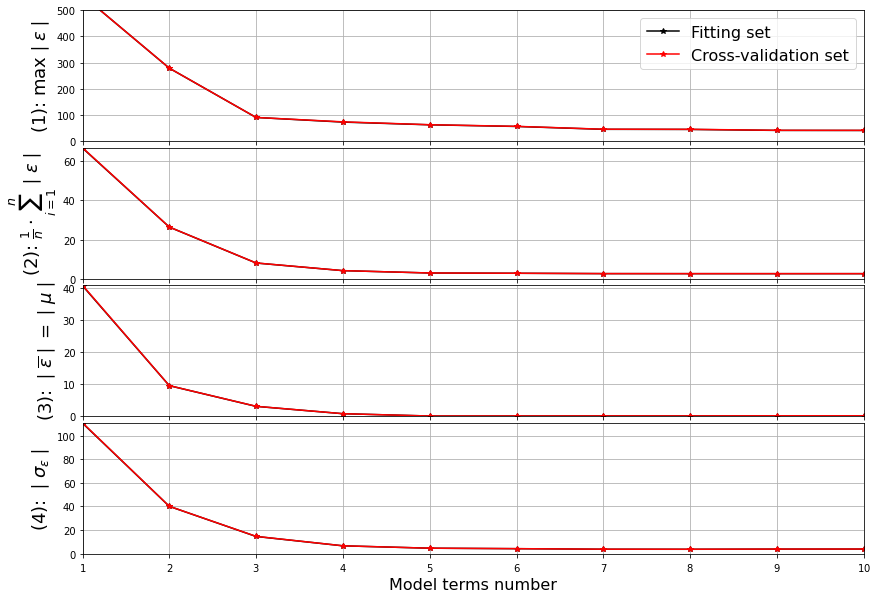

In [14]:
# Import pyVPLM modules/functions
from pyvplm.addon.variablepowerlaw import regression_models

# Fit with 2nd order polynomia model the obtained Pi DOE
models5 = regression_models(doePI2.values, elected_pi0='pi1', order=2, log_space=False, ymax_axis=500)


Elected model for regression is n°4:


<IPython.core.display.Latex object>

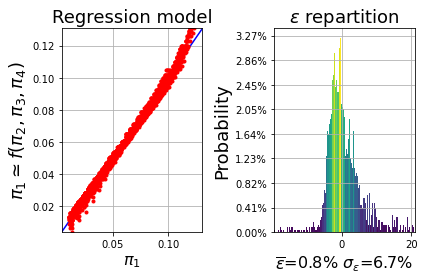

In [15]:
# Import pyVPLM modules/functions
from pyvplm.addon.variablepowerlaw import perform_regression

# Plot advanced result for model n°4
expression, expression_latex = perform_regression(doePI2.values, models5, chosen_model=4)

> **Conclusion**: the polynomial form expression is way simpler for the same fidelity, therefore, polynomial form should be used for propeller regression. In addition, null $C_{t}$ values can be considered.